In [1]:
"""
Universal Function Approximators 函数拟合器
Multi-layer Perceptrons (NN) is Universal Approximators provided sufficiently broad and deep
http://deeplearning.cs.cmu.edu/F20/index.html
"""

import numpy as np

In [2]:
class Layer:
    """ A Fully Connected Layer """
    def __init__(self, n_input, n_output, activation=None, weights=None, bias=None):
        """
        :param int n_input: Number of input nodes/neurons of previous layer
        :param int n_output: Number of output nodes/neurons of this layer
        :param str activation: Type of activation function
        :param weights : Weight of input connections
        :param bias : Bias of input connections
        """
        self.weights = weights if weights is not None else np.random.randn(n_input, n_output) / np.sqrt(n_input) * 2 # Normalization
        self.bias = bias if bias is not None else np.random.rand(n_output) * 0.2
        self.weights_update = np.zeros_like(self.weights)  # weights_new = weights_old + weights_update
        self.bias_update = np.zeros_like(self.bias)  # bias_new = bias_old + bias_update
        self.activation = activation  # relu tanh or sigmoid
        self.activation_output = None  # Output/activation value of this layer
        self.error = None  # Error or discrepancy of output/activation value
        self.delta = None  # Delta of X@W + b, delta = error*activation_derivative(output)
    def activate(self, X):
        # Forward propagation function
        r = np.dot(X, self.weights) + self.bias # X@W + b
        # Output of fully connected layer, o (activation_output)
        self.activation_output = self._apply_activation(r)
        return self.activation_output
    def _apply_activation(self, r):
        if self.activation is None:
            return r
        elif self.activation == 'relu':
            return np.maximum(r, 0)
        elif self.activation == 'tanh':
            return np.tanh(r)
        elif self.activation == 'sigmoid':
            return 1 / (1 + np.exp(-r))
        return r
    def apply_activation_derivative(self, y):
        # Calculate the derivative of activation function
        if self.activation is None: # No activation function, derivative is 1
            return np.ones_like(y)
        # ReLU
        elif self.activation == 'relu':
            grad = np.array(y, copy=True)
            grad[y > 0] = 1.
            grad[y <= 0] = 0.
            return grad
        # Tanh
        elif self.activation == 'tanh':
            return 1 - y ** 2
        # Sigmoid
        elif self.activation == 'sigmoid':
            return y * (1 - y)
        return y

In [8]:
class NeuralNetwork:
    def __init__(self):
        self._layers = []
    def add_layer(self, layer):
        self._layers.append(layer)
    def feed_forward(self, X):
        # Forward propagation
        for layer in self._layers:
            X = layer.activate(X)
        return X
    def backpropagation(self, X, y, learning_rate):
        # Calculate delta of each layer
        output = self.feed_forward(X)
        for i in reversed(range(len(self._layers))): # reverse looping
            layer = self._layers[i]
            if layer == self._layers[-1]: # output layer
                layer.error = y - output
                # calculate delta of final layer
                layer.delta = layer.error * layer.apply_activation_derivative(output)
            else: # hidden layer
                next_layer = self._layers[i + 1]
                layer.error = np.dot(next_layer.weights, next_layer.delta)
                layer.delta = layer.error*layer.apply_activation_derivative(layer.activation_output)
        # Calculate weight_update and bias_update
        for i in range(len(self._layers)):
            layer = self._layers[i]
            # o_i is the output/activation value of previous layer
            o_i = np.atleast_2d(X if i == 0 else self._layers[i - 1].activation_output)
            layer.weights_update += layer.delta * o_i.T * learning_rate
            layer.bias_update += layer.delta * learning_rate
    def train(self, X_train, X_test, y_train, y_test, learning_rate, max_epochs, batch_size):
        mses = []  # Mean square errors
        for i in range(max_epochs):
            for j in range(len(X_train)):  # one sample each train
                self.backpropagation(X_train[j], y_train[j], learning_rate)
                if j % batch_size == batch_size - 1:  # averaging over this batch
                    for k in range(len(self._layers)):
                        layer = self._layers[k]
                        layer.weights += layer.weights_update / batch_size
                        layer.bias += layer.bias_update / batch_size
                        layer.weights_update = np.zeros_like(layer.weights)  # resatrt averaging over this batch
                        layer.bias_update = np.zeros_like(layer.bias)
            if i % 10 == 0:
                # print MSE Loss
                mse = np.mean(np.square(y_train - self.feed_forward(X_train)))
                mse_test = np.mean(np.square(y_test - self.feed_forward(X_test)))
                mses.append(mse)
                print('Epoch: #%s, Train MSE: %f, Test MSE: %f' %(i, float(mse), float(mse_test)))
        return mses

In [4]:
def f(X):
    """
    y =  sin(x0) + sin(x1)
    """
    return np.sum(np.sin(X), axis = 1)

In [21]:
num_train = 200
num_test = 20
X_train = np.random.rand(num_train,2) * 5  # x1 x2 [0-5]
y_train = f(X_train).reshape(num_train,1) + 2 * np.random.rand(num_train,1)
X_test = np.random.rand(num_test,2) * 5
y_test = f(X_test).reshape(num_test,1)

In [22]:
nn = NeuralNetwork()  # 3 layers, 2 inputs, 1 outputs
nn.add_layer(Layer(2, 20 , 'sigmoid'))  # hidden layer 1, 2 input => 20 output
nn.add_layer(Layer(20, 20, 'sigmoid'))  # hidden layer 2, 20 => 20
nn.add_layer(Layer(20, 1))  # output layer, 20 => 1, no activation

mses = nn.train(X_train, X_test, y_train, y_test, learning_rate=0.1, max_epochs=201, batch_size=1)

Epoch: #0, Train MSE: 1.278977, Test MSE: 1.395598
Epoch: #10, Train MSE: 0.575587, Test MSE: 0.766250
Epoch: #20, Train MSE: 0.460816, Test MSE: 0.675314
Epoch: #30, Train MSE: 0.369823, Test MSE: 0.795702
Epoch: #40, Train MSE: 0.344405, Test MSE: 0.860392
Epoch: #50, Train MSE: 0.335431, Test MSE: 0.881849
Epoch: #60, Train MSE: 0.328478, Test MSE: 0.912923
Epoch: #70, Train MSE: 0.322695, Test MSE: 0.948636
Epoch: #80, Train MSE: 0.318173, Test MSE: 0.982734
Epoch: #90, Train MSE: 0.314649, Test MSE: 1.013147
Epoch: #100, Train MSE: 0.311816, Test MSE: 1.039793
Epoch: #110, Train MSE: 0.309434, Test MSE: 1.063270
Epoch: #120, Train MSE: 0.307341, Test MSE: 1.084198
Epoch: #130, Train MSE: 0.305434, Test MSE: 1.103033
Epoch: #140, Train MSE: 0.303653, Test MSE: 1.120067
Epoch: #150, Train MSE: 0.301966, Test MSE: 1.135472
Epoch: #160, Train MSE: 0.300361, Test MSE: 1.149345
Epoch: #170, Train MSE: 0.298832, Test MSE: 1.161728
Epoch: #180, Train MSE: 0.297380, Test MSE: 1.172626
Epoc

In [24]:
mses = nn.train(X_train, X_test, y_train, y_test, learning_rate=0.1, max_epochs=201, batch_size=1)

Epoch: #0, Train MSE: 0.276012, Test MSE: 1.290893
Epoch: #10, Train MSE: 0.275578, Test MSE: 1.296555
Epoch: #20, Train MSE: 0.275174, Test MSE: 1.302000
Epoch: #30, Train MSE: 0.274799, Test MSE: 1.307217
Epoch: #40, Train MSE: 0.274450, Test MSE: 1.312199
Epoch: #50, Train MSE: 0.274127, Test MSE: 1.316946
Epoch: #60, Train MSE: 0.273826, Test MSE: 1.321459
Epoch: #70, Train MSE: 0.273545, Test MSE: 1.325740
Epoch: #80, Train MSE: 0.273283, Test MSE: 1.329792
Epoch: #90, Train MSE: 0.273035, Test MSE: 1.333619
Epoch: #100, Train MSE: 0.272801, Test MSE: 1.337225
Epoch: #110, Train MSE: 0.272576, Test MSE: 1.340612
Epoch: #120, Train MSE: 0.272360, Test MSE: 1.343784
Epoch: #130, Train MSE: 0.272151, Test MSE: 1.346743
Epoch: #140, Train MSE: 0.271946, Test MSE: 1.349492
Epoch: #150, Train MSE: 0.271744, Test MSE: 1.352033
Epoch: #160, Train MSE: 0.271543, Test MSE: 1.354367
Epoch: #170, Train MSE: 0.271343, Test MSE: 1.356497
Epoch: #180, Train MSE: 0.271143, Test MSE: 1.358424
Epoc

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
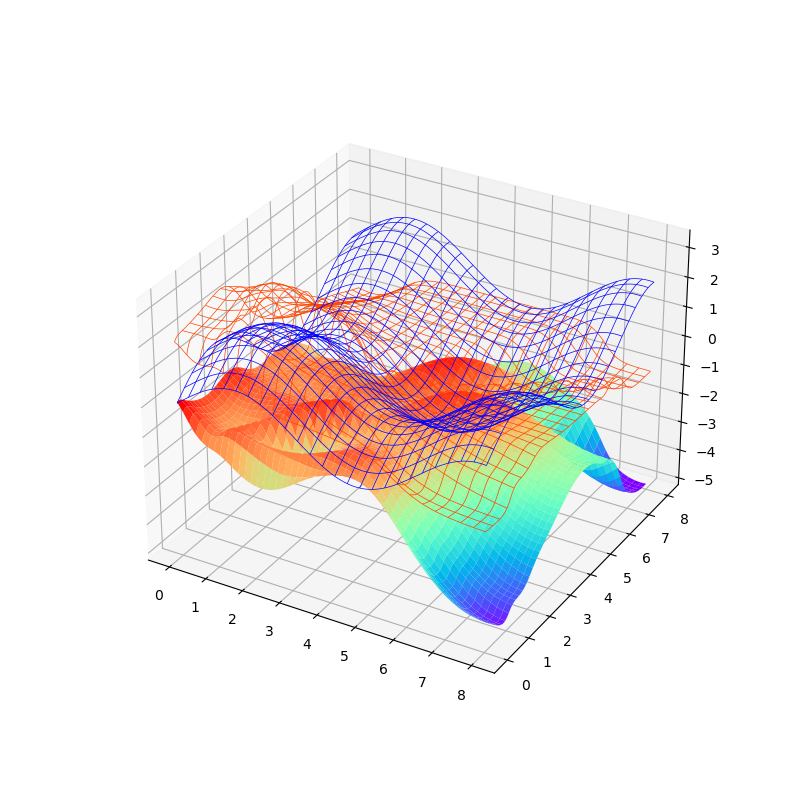

In [25]:
%matplotlib widget
import matplotlib.pyplot as plt

n = 500
x0, x1 = np.meshgrid(np.linspace(0, 8, n), np.linspace(0, 8, n))
y = np.sin(x0) + np.sin(x1)
X_new = np.c_[x0.ravel(), x1.ravel()]
y_predict = nn.feed_forward(X_new).reshape(n,n)

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': '3d'})
ax.plot_wireframe(x0, x1, y, rstride=20,
                  cstride=20, linewidth=0.5,
                  color='blue')
ax.plot_wireframe(x0, x1, y_predict, rstride=20,
                  cstride=20, linewidth=0.5,
                  color='orangered')
ax.plot_surface(x0, x1, y_predict-y-2, cmap=plt.get_cmap('rainbow'))